Script para calcular los indicadores de la Encuesta de Convivencia y Seguridad Ciudadana 2019
y preparar los archivos con variables auxiliares, para su posterior uso.
@author: Diana Carolina Rodríguez

1. Se calculan los indicadores en base  los datos de la ECSC2019. 
2. Se genera la base de los indicadores calculados por municipio, y se agrega las variales socio-demográficas que se usarán para generar el modelo de los indicadores.
3. Se genera la base de las variables auxiliares de los municipios que no hacen parte de la muestra y cuyos indicadores se usarán através del modelo 

In [5]:
import numpy  as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
import warnings
warnings.filterwarnings('ignore')
import os
import glob
from functools import reduce

/opt/anaconda3/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [6]:
# Cargue de los archivos con las variables auxiliares
carpeta_actual = os.getcwd()
carpeta_archivos_csv = 'datos_dane'
ruta_archivos = os.path.join(carpeta_actual, carpeta_archivos_csv, '*.csv')
archivos_csv = glob.glob(ruta_archivos)

for archivo_csv in archivos_csv:
    nombre_df = os.path.splitext(os.path.basename(archivo_csv))[0]
    #print(nombre_df)
    globals()[f'df_{nombre_df}'] = pd.read_csv(archivo_csv, sep=';', error_bad_lines=False)

In [7]:
#Solo usamos las variables de ingresos y egresos del último año (2019)
dt_circuito=df_dt_circuito[['mpio_ccnct', 'ingresos_total', 'egresos_total', 'proporcion_total', 'ingresos_Promiscuo_2019', 'ingresos_Civil_2019', 'ingresos_Familia_2019', 'ingresos_Laboral_2019', 'ingresos_Penal_2019', 'egresos_Civil_2019', 'egresos_Familia_2019', 'egresos_Penal_2019', 'egresos_Laboral_2019', 'egresos_Promiscuo_2019', 'proporcion_Promiscuo_2019', 'proporcion_Familia_2019', 'proporcion_Laboral_2019', 'proporcion_Penal_2019', 'proporcion_Civil_2019']]
dt_censo = df_dt_cnpv  #variables_censo_población
dt_dane=df_dt_dane.drop(columns=['dpto_ccdgo', 'mpio_ccdgo']) #borramos columnas que no corresponden a variables auxiliares
dt_dane_demo=df_dt_dane_demo.drop(columns=('discapacidad'))  #Se borra esta variables porque los datos tienen muchos vacios y no están iguales a los revisados en la página del Dane
dt_just = df_dt_just #servicios_judiciales
dt_distrito=df_dt_distrito.drop(columns=['dpto_ccdgo', 'mpio_ccdgo', 'distrito']) #borramos columnas que no corresponden a variables auxiliares

In [8]:
#Cargar base de delitos
ruta_delitos = os.path.join(carpeta_actual, 'datos_delitos', 'dt_siedco.csv')
dt_siedco = pd.read_csv(ruta_delitos, sep = ',', error_bad_lines=False)
dt_siedco=dt_siedco.rename(columns={'CODIGO DANE':"mpio_ccnct"}) #renombramos variales con municipios
dt_siedco_2019=dt_siedco[(dt_siedco.ANIO.isin([2019]))] #usamos solo información de cimenes de 2019

In [9]:
dt_siedco_2019.head(2)

,DEPARTAMENTO,MUNICIPIO,mpio_ccnct,ARMAS MEDIOS,FECHA HECHO,GENERO,AGRUPA EDAD PERSONA,CANTIDAD,DELITO,ANIO,MES,DIA
22579,CESAR,BECERRIL,20045,SIN EMPLEO DE ARMAS,30/04/2019,MASCULINO,ADULTOS,1,Abigeato,2019,4,30
22580,CESAR,VALLEDUPAR (CT),20001,SIN EMPLEO DE ARMAS,15/03/2019,MASCULINO,ADULTOS,1,Abigeato,2019,3,15


In [10]:
#Filtro los municipios donde hay muestra
dataframes_filtro = [dt_circuito, dt_censo, dt_dane, dt_dane_demo, dt_just, dt_distrito, dt_siedco_2019]

nombres_filtrados = ['dt_circuito_mun', 'dt_censo_mun', 'dt_dane_mun', 'dt_dane_demo_muni', 'dt_just_muni', 'dt_distrito_muni', 'dt_siedco_muni']

for i in range(len(dataframes_filtro)):
    dataframes_filtro[i] = dataframes_filtro[i][dataframes_filtro[i].mpio_ccnct.isin([5001, 8001, 11001, 13001, 17001, 23001, 50001, 52001, 54001, 66001, 68001, 73001, 76001])]
    globals()[nombres_filtrados[i]] = dataframes_filtro[i]

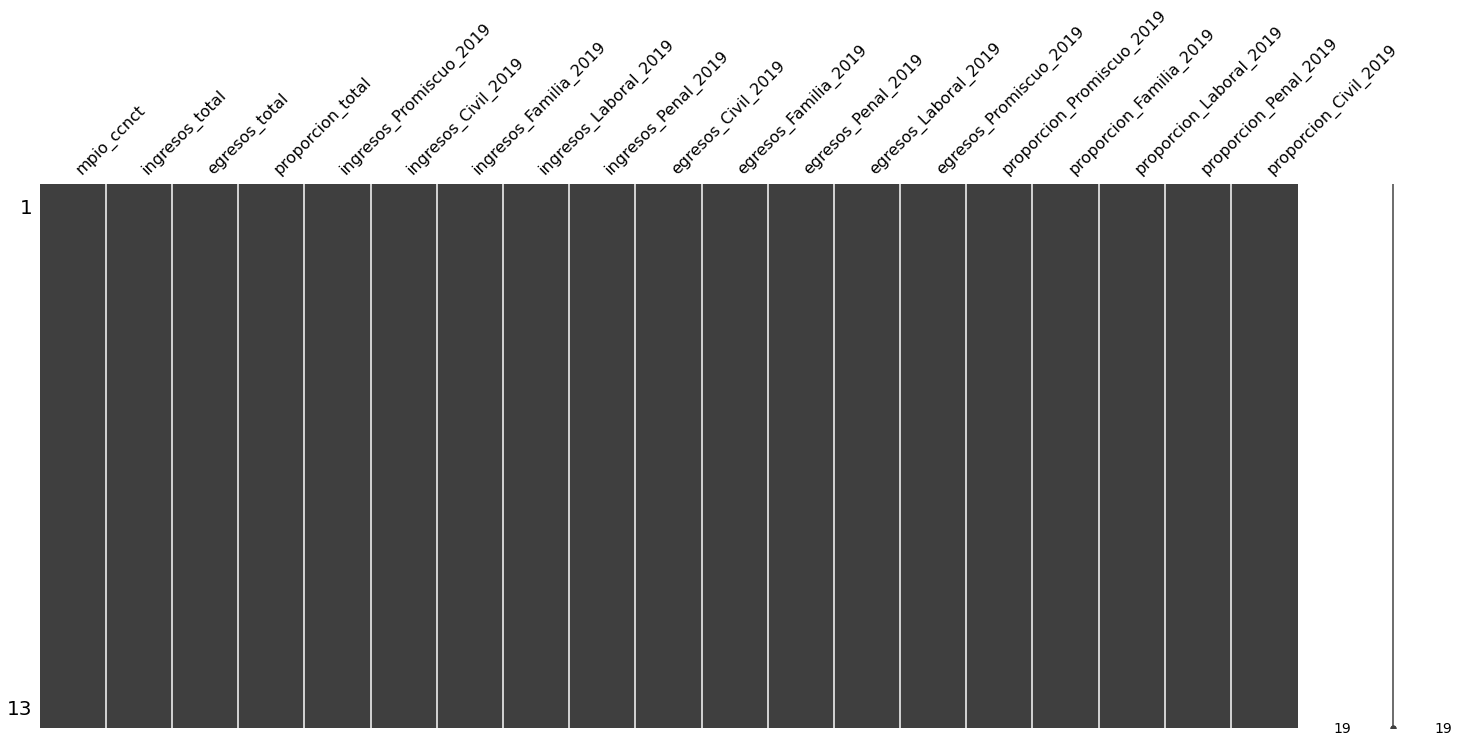

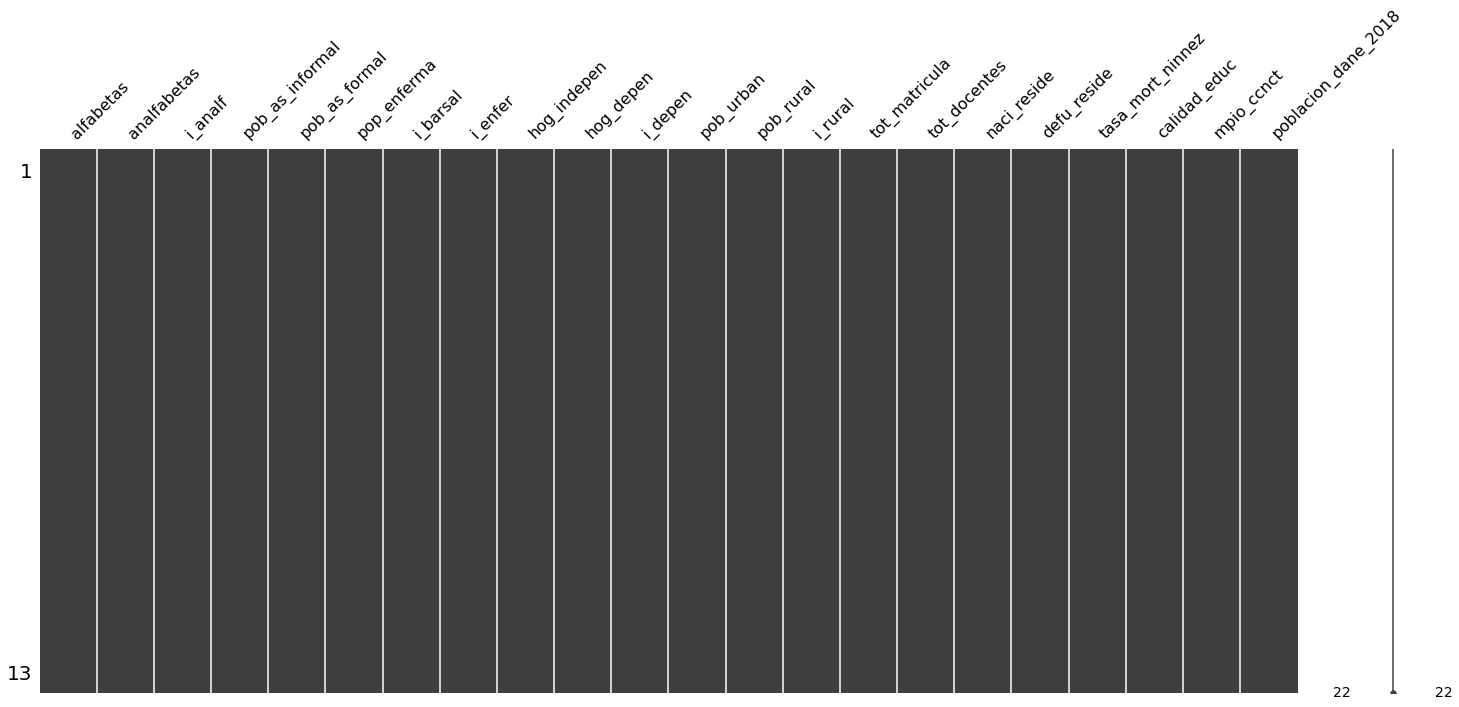

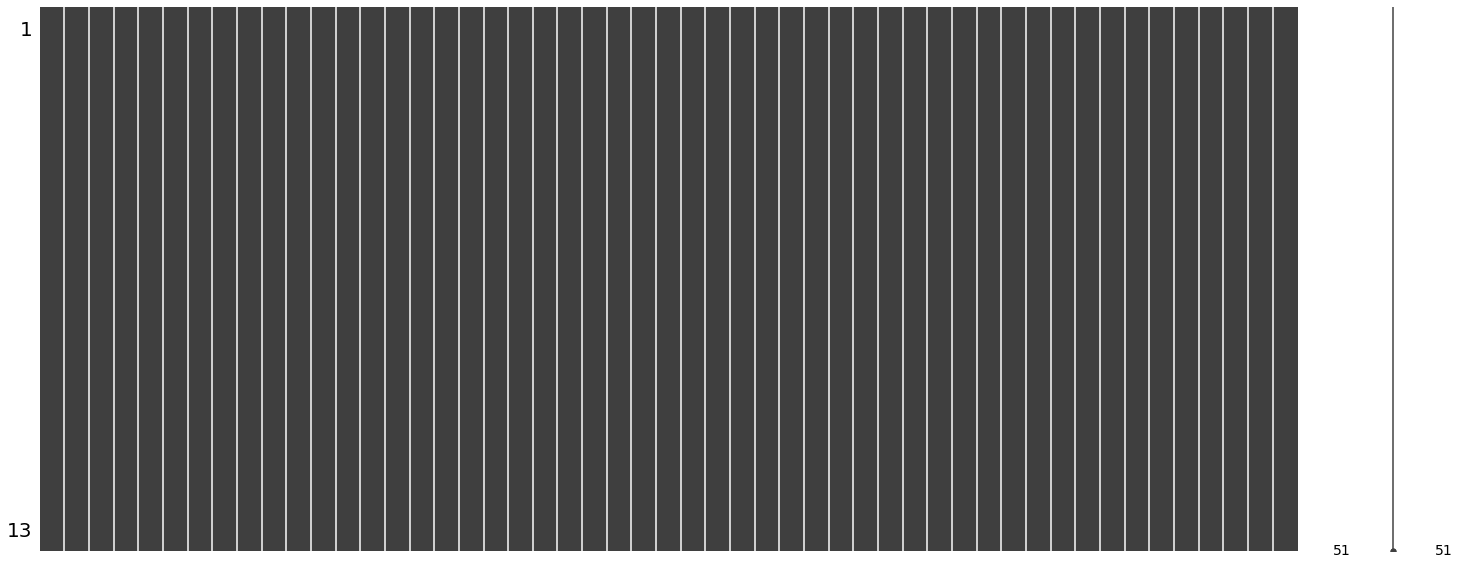

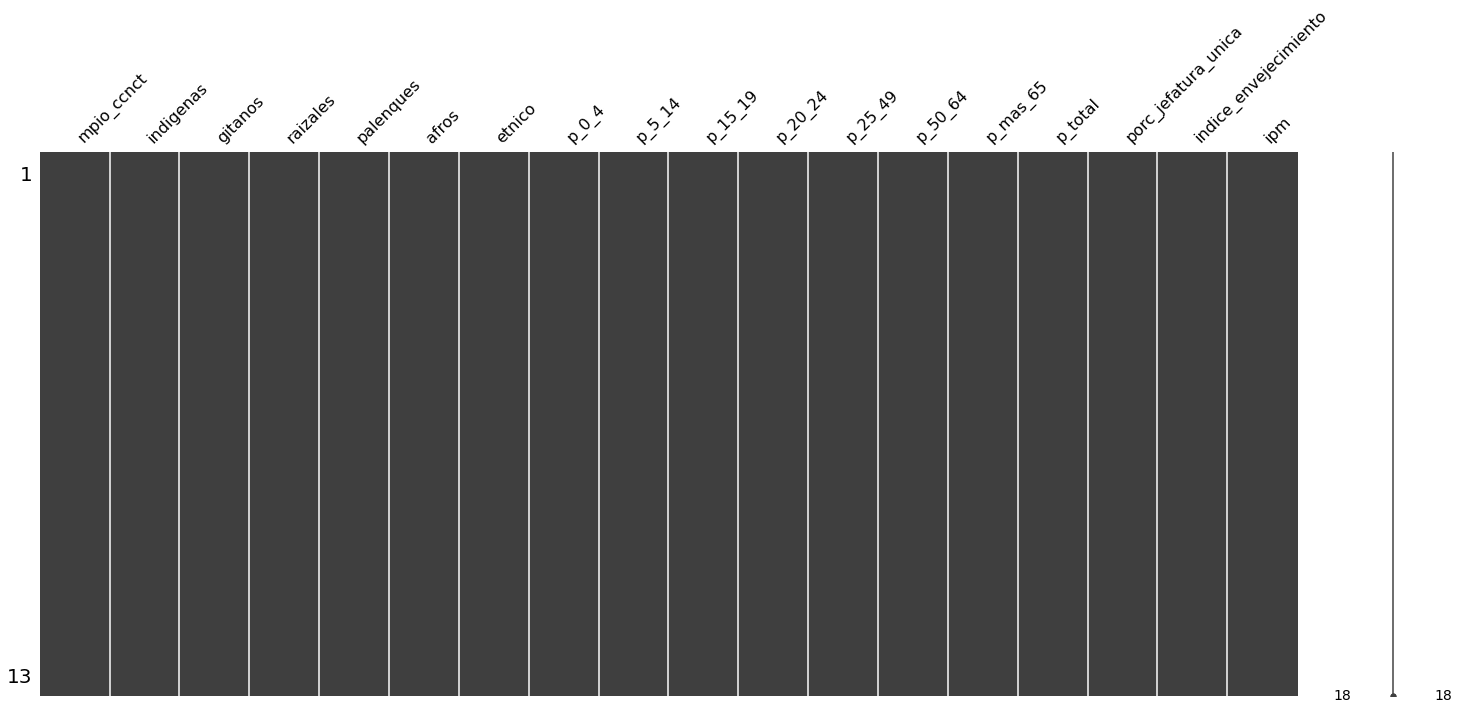

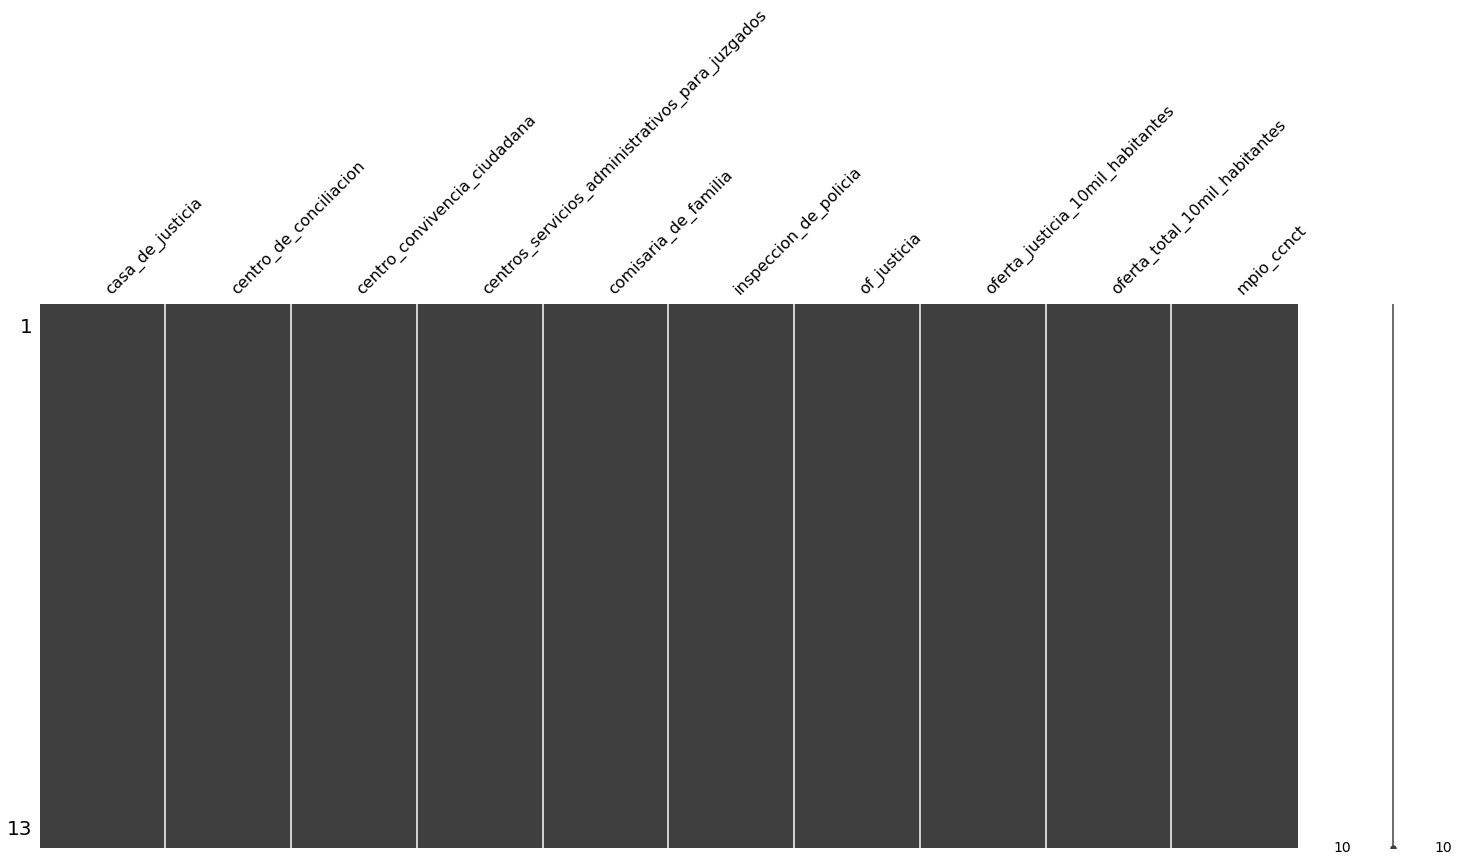

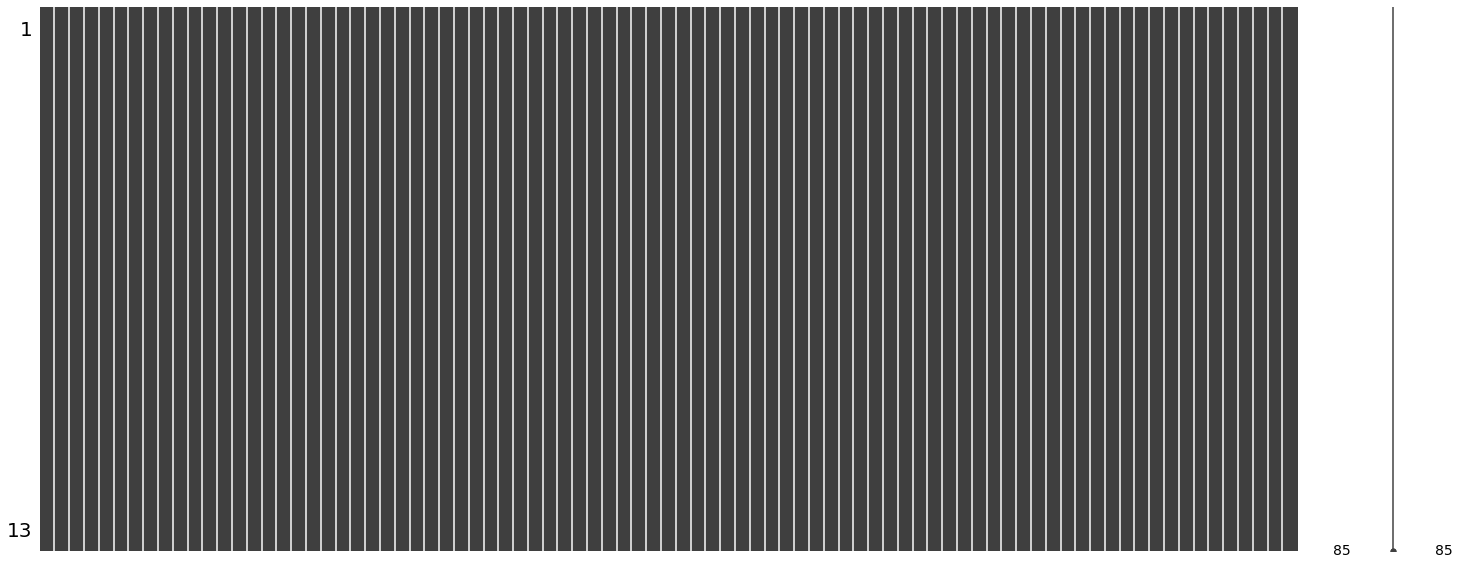

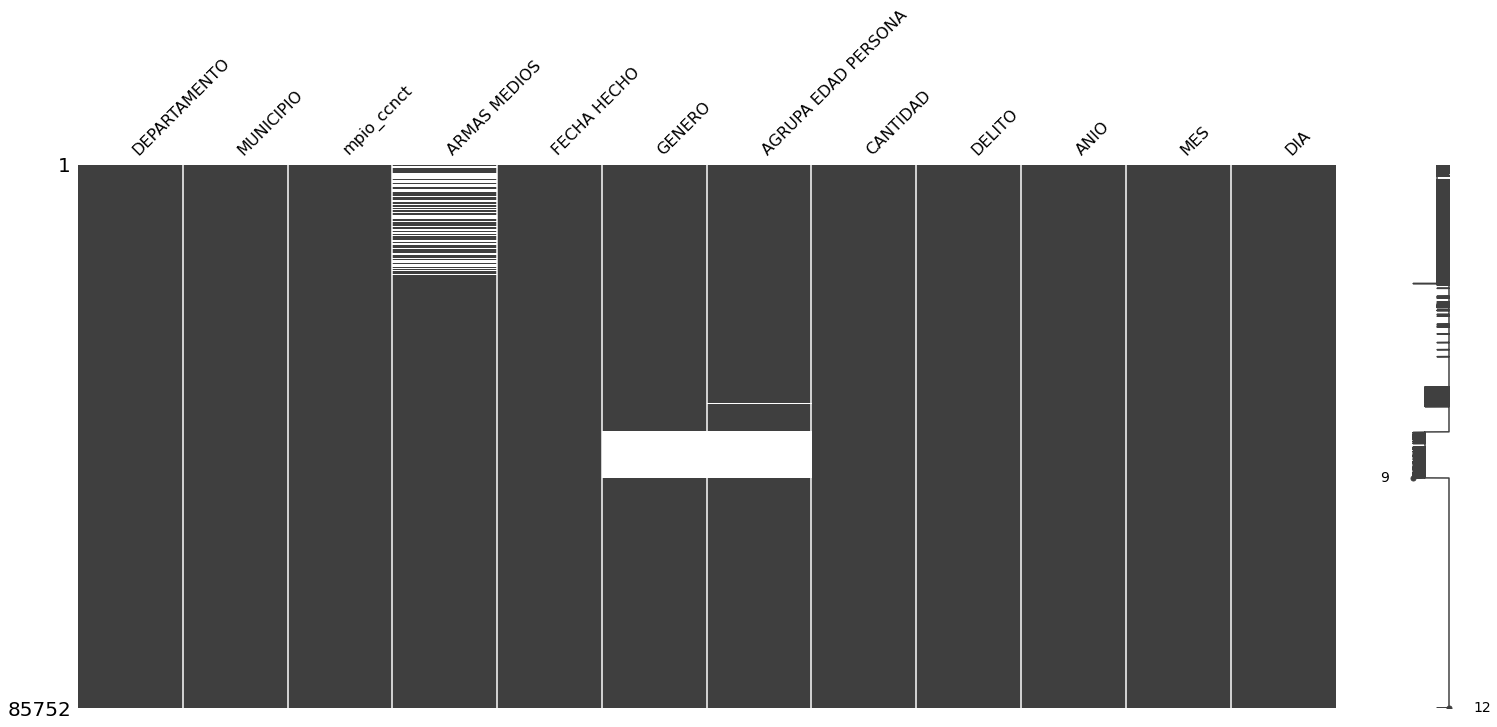

In [11]:
#Graficamos los valores faltantes
for i in [dt_circuito_mun, dt_censo_mun, dt_dane_mun, dt_dane_demo_muni, dt_just_muni, dt_distrito_muni, dt_siedco_muni]:
    msno.matrix(i)

In [12]:
#Agregamos la base de delitos a nivel departamental
dt_siedco_df=pd.DataFrame(dt_siedco_muni.groupby(['mpio_ccnct', 'DELITO'])['DELITO'].count()) #agrupamos información de delitos por municipio
dt_siedco_df1=dt_siedco_df.unstack(1)
dt_siedco_df1.columns=['Abigeato', 'Amenazas', 'DelitosSexuales', 'Extorsion', 'Homicidios', 'HurtoAutomotores', 'HurtoComercio', 'HurtoFinancieras']

In [13]:
#Se crea la Base de Datos Delitos Municipios completos, se usa para los modelos
dt_siedco_df_compl=pd.DataFrame(dt_siedco_2019.groupby(['mpio_ccnct', 'DELITO'])['DELITO'].count())
dt_siedco_df1_compl=dt_siedco_df_compl.unstack(1)
#Se cambia el nombre de las columnas de la base de delito completa
dt_siedco_df1_compl.columns=['Abigeato', 'Amenazas', 'DelitosSexuales', 'Extorsion', 'Homicidios', 'HurtoAutomotores', 'HurtoComercio', 'HurtoFinancieras']
#Si hay n/a quiere decir que no hay delitos, entonces se cambia por cero
dt_siedco_df1_compl=dt_siedco_df1_compl.reset_index().fillna(0)

In [14]:
# Combino los dataframe con las variables auxiliares
dataframes_a_combinar = [dt_siedco_df1, dt_censo_mun, dt_circuito_mun, dt_dane_demo_muni, dt_distrito_muni, dt_just_muni, dt_dane_mun]
Var_aux = reduce(lambda left, right: pd.merge(left, right, how='right', on='mpio_ccnct'), dataframes_a_combinar)

In [15]:
#Se crea una Base_de_datos_con_todos_municipios sin la info de dt_circuito y dt_distrito, que no cuentan con información de todos los municipios
dataframes_a_combinar_fin = [dt_siedco_df1_compl, dt_censo, dt_dane_demo, dt_just, dt_dane]
Registros_compl = reduce(lambda left, right: pd.merge(left, right, how='right', on='mpio_ccnct'), dataframes_a_combinar)

In [16]:
Registros_compl.head(2)

,mpio_ccnct,Abigeato,Amenazas,DelitosSexuales,Extorsion,Homicidios,HurtoAutomotores,HurtoComercio,HurtoFinancieras,alfabetas,...,safam_cprd,sas_tot,sas_cab,sas_cprd,trinf_tot,trinf_cab,trinf_cprd,triml_tot,triml_cab,triml_cprd
0,76001,20.0,3999.0,1995.0,500.0,1114.0,2103.0,3976.0,18.0,1645436,...,"7,1","17,7","17,8","16,5","0,6","0,5","0,7","75,3","75,1","80,6"
1,52001,8.0,865.0,527.0,76.0,53.0,83.0,541.0,NaN,315714,...,"5,9",15,16,"11,2","0,8","0,5","2,1","81,8","79,9","89,8"


In [17]:
#Ahora cargo los archivos de la encuesta ECSC
ruta_delitos = os.path.join(carpeta_actual, 'ECSC2019', 'Cálculo_indicadores', '*.csv')
archivos_delitos = glob.glob(ruta_delitos)
dataframes_ecsc = []

for archivo_delitos in archivos_delitos:
    df = pd.read_csv(archivo_delitos, sep=';', error_bad_lines=False)
    dataframes_ecsc.append(df)

# Asigno un nombre a cada archivo
nombres_variables = ['disp_larg_con', 'd_viv', 'car_gen_ini', 'disp_larg_sin', 'car_gen']

for i, nombre_variable in enumerate(nombres_variables):
    # Puedes acceder a los DataFrames por su índice en la lista
    globals()[f'ECSC_{nombre_variable}'] = dataframes_ecsc[i]

In [18]:
ECSC_d_viv.head(2)

,DIRECTORIO,NRO_ENCUESTA,SECUENCIA_ENCUESTA,SECUENCIA_P,ORDEN,FEX_C,DEPMUNI,CIUDADES28,CLASE,P1987,P1988,P1988S1,P1989,P1990
0,501433,235,1,1,1,"108,419842080992",13001,1,Cabecera,2,1,2,2,1
1,501434,235,1,1,1,"94,5309979723164",13001,1,Cabecera,2,1,2,2,1


In [19]:
#Generamos las llaves y obtenemos una base con las variables que necesitamos de la ECSC
for i in [ECSC_car_gen_ini, ECSC_disp_larg_con, ECSC_disp_larg_sin, ECSC_car_gen]:
    i['llave']=i[['DIRECTORIO', 'NRO_ENCUESTA', 'SECUENCIA_ENCUESTA', 'SECUENCIA_P', 'ORDEN']].astype(str).apply(''.join, axis=1)

Base=ECSC_car_gen[['llave', 'P6210']]
Base1=pd.merge(Base, ECSC_car_gen_ini[['DIRECTORIO', 'llave', 'P220']], on='llave', how='left')
Base2=pd.merge(Base1, ECSC_disp_larg_con[['llave', 'P1683_2', 'P1683_1', 'P1672_2', 'P1672_1', 'P1689_1', 'P1689_2', 'P1676_1', 'P1676_2', 'P1687_1', 'P1687_2', 'P1684_1', 'P1684_2', 'P1685_1', 'P1685_2']], on='llave', how='left')
Base3=pd.merge(Base2, ECSC_disp_larg_sin[['llave', 'P1683', 'P1672', 'P1689', 'P1676', 'P1687', 'P1684', 'P1685']], on='llave', how='left')
Base_fin=pd.merge(Base3, ECSC_d_viv[['DIRECTORIO','FEX_C', 'DEPMUNI', 'CIUDADES28']], on='DIRECTORIO', how='left')

Base_fin['FEX_C'] = Base_fin['FEX_C'].apply(lambda x: float(x.replace(',', '.')) if isinstance(x, str) else x)
Base_fin['FEX_C'].sum() #verificamos la suma de los factores de expansión=Poblacion de Colombia en el área de estudio

37645791.57791969

In [20]:
#Limpiamos la base, cambiamos n/a y vacios por ceros y convertimos las variables a numéricas
Base_fin = Base_fin.replace([r'^\s*$', " ", np.nan], 0, regex=True)
Base_fin=Base_fin.apply(pd.to_numeric, errors='coerce')

In [21]:
#Hacemos el cálculo de los Indicadores de la Encuesta de Convivencia y Seguridad Ciudadana
#Preparamos variables 
#Numerador Indicador "Desconocimientno Rutas de acción"
Base_fin['num_des_rutas_lcp1']=Base_fin['P1683_1'].replace({1:0, 2:0, 3:1, 4:0, 5:1, 6:0, 7:0, 8:0, 9:0, 10:0, np.nan: 0})
Base_fin['num_des_rutas_lcp2']=Base_fin['P1683_2'].replace({1:0, 2:0, 3:1, 4:0, 5:1, 6:0, 7:0, 8:0, 9:0, 10:0, np.nan: 0})
Base_fin['num_des_rutas_lsp']=Base_fin['P1683'].replace({1:0, 2:0, 3:1, 4:0, 5:1, 6:0, 7:0, 8:0, 9:0, 10:0, np.nan: 0})
#Preparamos variables 
#Denominador Indicador "Desconocimiento Rutas de acción"
Base_fin['den_des_rutas_lcp1']=Base_fin['P1672_1'].replace({1:0, 2:0, 3:0, 4:0, 5:1, np.nan: 0}) 
Base_fin['den_des_rutas_lcp2']=Base_fin['P1672_2'].replace({1:0, 2:0, 3:0, 4:0, 5:1, np.nan: 0})
Base_fin['den_des_rutas_lsp']=Base_fin['P1672'].replace({1:0, 2:0, 3:0, 4:0, 5:1, np.nan: 0})
#Numerador Indicador "Acceso asesoría legal"
Base_fin['num_acc_ase_lcp1']=Base_fin['P1689_1'].replace({1:1, 2:1, 3:1, 4:1, 5:0, np.nan: 0})
Base_fin['num_acc_ase_lcp2']=Base_fin['P1689_2'].replace({1:1, 2:1, 3:1, 4:1, 5:0, np.nan: 0})
Base_fin['num_acc_ase_lsp']=Base_fin['P1689'].replace({1:1, 2:1, 3:1, 4:1, 5:0, np.nan: 0})
#Denominador Indicador "Acceso asesoría legal"
Base_fin['den_acc_ase_lcp1']=Base_fin['P1672_1'].replace({1:1, 2:1, 3:1, 4:1, 5:1, np.nan: 0}) 
Base_fin['den_acc_ase_lcp2']=Base_fin['P1672_2'].replace({1:1, 2:1, 3:1, 4:1, 5:1, np.nan: 0})
Base_fin['den_acc_ase_lsp']=Base_fin['P1672'].replace({1:1, 2:1, 3:1, 4:1, 5:1, np.nan: 0})
#Numerador Indicador "Escolaridad"
Base_fin['num_escol']=Base_fin['P6210'].replace({1:0, 2:0, 3:0, 4:1, 5:1, 6:1, 7:1, 8:1, 9:0, np.nan: 0})
#Numerador Indicador "Percepción negativo servicios de justicia" 
Base_fin['num_per_sv_jus_lcp1']=Base_fin['P1683_1'].replace({1:0, 2:1, 3:1, 4:0, 5:0, 6:0, 7:0, 8:0, 9:0, 10:0, np.nan: 0})
Base_fin['num_per_sv_jus_lcp2']=Base_fin['P1683_2'].replace({1:0, 2:1, 3:1, 4:0, 5:0, 6:0, 7:0, 8:0, 9:0, 10:0, np.nan: 0})
Base_fin['num_per_sv_jus_lsp']=Base_fin['P1683'].replace({1:0, 2:1, 3:1, 4:0, 5:0, 6:0, 7:0, 8:0, 9:0, 10:0, np.nan: 0})
#Denominador Indicador "Percepción negativa servicios de justicia" 
Base_fin['den_per_sv_jus_lcp1']=Base_fin['P1672_1'].replace({1:0, 2:0, 3:0, 4:0, 5:1, np.nan: 0}) 
Base_fin['den_per_sv_jus_lcp2']=Base_fin['P1672_2'].replace({1:0, 2:0, 3:0, 4:0, 5:1, np.nan: 0})
Base_fin['den_per_sv_jus_lsp']=Base_fin['P1672'].replace({1:0, 2:0, 3:0, 4:0, 5:1, np.nan: 0})
#Numerador Indicador "Resultados de asistir a una institución para resolver las necesidades jurídicas"
Base_fin['num_rta_asist_inst_lcp1']=Base_fin['P1676_1'].replace({1:1, 2:1, 3:0, 4:0, 5:0, 6:0, np.nan: 0})
Base_fin['num_rta_asist_inst_lcp2']=Base_fin['P1676_2'].replace({1:1, 2:1, 3:0, 4:0, 5:0, 6:0, np.nan: 0})
Base_fin['num_rta_asist_inst_lsp']=Base_fin['P1676'].replace({1:1, 2:1, 3:0, 4:0, 5:0, 6:0, np.nan: 0})
#Denominador Indicador "Resultados de asistir a una institución para resolver las necesidades jurídicas"
Base_fin['den_rta_asist_inst_lcp1']=Base_fin['P1672_1'].replace({1:1, 2:0, 3:0, 4:0, 5:0, np.nan: 0})
Base_fin['den_rta_asist_inst_lcp2']=Base_fin['P1672_2'].replace({1:1, 2:0, 3:0, 4:0, 5:0, np.nan: 0})
Base_fin['den_rta_asist_inst_lsp']=Base_fin['P1672'].replace({1:1, 2:0, 3:0, 4:0, 5:0, np.nan: 0})
#Numerador Indicador "Confianza en las instituciones"
Base_fin['num_conf_inst_lcp1']=Base_fin['P1687_1'].replace({1:1, 2:0, np.nan: 0}) 
Base_fin['num_conf_inst_lcp2']=Base_fin['P1687_2'].replace({1:1, 2:0, np.nan: 0})
Base_fin['num_conf_inst_lsp']=Base_fin['P1687'].replace({1:1, 2:0, np.nan: 0})
#Denominador Indicador "Confianza en las instituciones"
Base_fin['den_conf_inst_lcp1']=Base_fin['P1672_1'].replace({1:1, 2:0, 3:0, 4:0, 5:0, np.nan: 0}) 
Base_fin['den_conf_inst_lcp2']=Base_fin['P1672_2'].replace({1:1, 2:0, 3:0, 4:0, 5:0, np.nan: 0})
Base_fin['den_conf_inst_lsp']=Base_fin['P1672'].replace({1:1, 2:0, 3:0, 4:0, 5:0, np.nan: 0})
#Numerador condicionado Indicador "Confianza en las instituciones"
Base_fin['num_conf_inst_lcp1']=Base_fin['num_conf_inst_lcp1']*Base_fin['den_conf_inst_lcp1']
Base_fin['num_conf_inst_lcp2']=Base_fin['num_conf_inst_lcp2']*Base_fin['den_conf_inst_lcp2']
Base_fin['num_conf_inst_lsp']=Base_fin['num_conf_inst_lsp']*Base_fin['den_conf_inst_lsp']
#Numerador Indicador "Cumplimiento decisiones"
Base_fin['num_cumpl_lcp1']=Base_fin['P1684_1'].replace({1:1, 2:0, np.nan: 0}) 
Base_fin['num_cumpl_lcp2']=Base_fin['P1684_2'].replace({1:1, 2:0, np.nan: 0})
Base_fin['num_cumpl_lsp']=Base_fin['P1684'].replace({1:1, 2:0, np.nan: 0})
#Denominador Indicador "Cumplimiento decisiones"
Base_fin['den_cumpl_lcp1']=Base_fin['P1676_1'].replace({1:1, 2:1, 3:0, 4:0, 5:0, 6:0, np.nan: 0})
Base_fin['den_cumpl_lcp2']=Base_fin['P1676_2'].replace({1:1, 2:1, 3:0, 4:0, 5:0, 6:0, np.nan: 0})
Base_fin['den_cumpl_lsp']=Base_fin['P1676'].replace({1:1, 2:1, 3:0, 4:0, 5:0, 6:0, np.nan: 0})
#Numerador condicionado Indicador "Cumplimiento decisiones"
Base_fin['num_cumpl_lcp1']=Base_fin['num_cumpl_lcp1']*Base_fin['den_conf_inst_lcp1']*Base_fin['den_cumpl_lcp1']
Base_fin['num_cumpl_lcp2']=Base_fin['num_cumpl_lcp2']*Base_fin['den_conf_inst_lcp2']*Base_fin['den_cumpl_lcp2']
Base_fin['num_cumpl_lsp']=Base_fin['num_cumpl_lsp']*Base_fin['den_conf_inst_lsp']*Base_fin['den_cumpl_lsp']
#Numerador Indicador "Necesidades Jurídicas satisfechas"
Base_fin['num_nec_jur_lcp1']=Base_fin['P1685_1'].replace({1:1, 2:0, 9:0, np.nan: 0}) 
Base_fin['num_nec_jur_lcp2']=Base_fin['P1685_2'].replace({1:1, 2:0, 9:0, np.nan: 0})
Base_fin['num_nec_jur_lsp']=Base_fin['P1685'].replace({1:1, 2:0, 9:0, np.nan: 0})
#Denominador Indicador "Necesidades Jurídicas satisfechas"
Base_fin['den_nec_jur_lcp1']=Base_fin['P1672_1'].replace({1:1, 2:0, 3:0, 4:0, 5:0, np.nan: 0}) 
Base_fin['den_nec_jur_lcp2']=Base_fin['P1672_2'].replace({1:1, 2:0, 3:0, 4:0, 5:0, np.nan: 0})
Base_fin['den_nec_jur_lsp']=Base_fin['P1672'].replace({1:1, 2:0, 3:0, 4:0, 5:0, np.nan: 0})
#Numerador condicionado Indicador "Necesidades Jurídicas satisfechas"
Base_fin['num_nec_jur_lcp1']=Base_fin['num_nec_jur_lcp1']*Base_fin['den_nec_jur_lcp1']
Base_fin['num_nec_jur_lcp2']=Base_fin['num_nec_jur_lcp2']*Base_fin['den_nec_jur_lcp2']
Base_fin['num_nec_jur_lsp']=Base_fin['num_nec_jur_lsp']*Base_fin['den_nec_jur_lsp']
#Numerador Indicador "Efectividad del acuerdo del Pacífico"
Base_fin['num_efec_pac_lcp1']=Base_fin['P1685_1'].replace({1:1, 2:0, 9:0, np.nan: 0})
Base_fin['num_efec_pac_lcp2']=Base_fin['P1685_2'].replace({1:1, 2:0, 9:0, np.nan: 0})
Base_fin['num_efec_pac_lsp']=Base_fin['P1685'].replace({1:1, 2:0, 9:0, np.nan: 0})
#Denominador Indicador "Efectividad del acuerdo del Pacífico"
Base_fin['den_efec_pac_lcp1']=Base_fin['P1672_1'].replace({1:0, 2:1, 3:0, 4:0, 5:0, np.nan: 0}) 
Base_fin['den_efec_pac_lcp2']=Base_fin['P1672_2'].replace({1:0, 2:1, 3:0, 4:0, 5:0, np.nan: 0})
Base_fin['den_efec_pac_lsp']=Base_fin['P1672'].replace({1:0, 2:1, 3:0, 4:0, 5:0, np.nan: 0})
#Numerador efectivida acuerdo pacifico
Base_fin['num_efec_pac_lcp1']=Base_fin['num_efec_pac_lcp1']*Base_fin['den_efec_pac_lcp1']
Base_fin['num_efec_pac_lcp2']=Base_fin['num_efec_pac_lcp2']*Base_fin['den_efec_pac_lcp2']
Base_fin['num_efec_pac_lsp']=Base_fin['num_efec_pac_lsp']*Base_fin['den_efec_pac_lsp']
#Numerador condicionado Indicador "Confianza en las instituciones"
Base_fin['num_conf_inst_lcp1']=Base_fin['num_conf_inst_lcp1']*Base_fin['den_conf_inst_lcp1']
Base_fin['num_conf_inst_lcp2']=Base_fin['num_conf_inst_lcp2']*Base_fin['den_conf_inst_lcp2']
Base_fin['num_conf_inst_lsp']=Base_fin['num_conf_inst_lsp']*Base_fin['den_conf_inst_lsp']
#Numerador Indicador "Cumplimiento decisiones"
Base_fin['num_cumpl_lcp1']=Base_fin['P1684_1'].replace({1:1, 2:0, np.nan: 0}) 
Base_fin['num_cumpl_lcp2']=Base_fin['P1684_2'].replace({1:1, 2:0, np.nan: 0})
Base_fin['num_cumpl_lsp']=Base_fin['P1684'].replace({1:1, 2:0, np.nan: 0})
#Denominador Indicador "Cumplimiento decisiones"
Base_fin['den_cumpl_lcp1']=Base_fin['P1676_1'].replace({1:1, 2:1, 3:0, 4:0, 5:0, 6:0, np.nan: 0})
Base_fin['den_cumpl_lcp2']=Base_fin['P1676_2'].replace({1:1, 2:1, 3:0, 4:0, 5:0, 6:0, np.nan: 0})
Base_fin['den_cumpl_lsp']=Base_fin['P1676'].replace({1:1, 2:1, 3:0, 4:0, 5:0, 6:0, np.nan: 0})
#Numerador condicionado Indicador "Cumplimiento decisiones"
Base_fin['num_cumpl_lcp1']=Base_fin['num_cumpl_lcp1']*Base_fin['den_conf_inst_lcp1']*Base_fin['den_cumpl_lcp1']
Base_fin['num_cumpl_lcp2']=Base_fin['num_cumpl_lcp2']*Base_fin['den_conf_inst_lcp2']*Base_fin['den_cumpl_lcp2']
Base_fin['num_cumpl_lsp']=Base_fin['num_cumpl_lsp']*Base_fin['den_conf_inst_lsp']*Base_fin['den_cumpl_lsp']
#Numerador Indicador "Necesidades Jurídicas satisfechas"
Base_fin['num_nec_jur_lcp1']=Base_fin['P1685_1'].replace({1:1, 2:0, 9:0, np.nan: 0}) 
Base_fin['num_nec_jur_lcp2']=Base_fin['P1685_2'].replace({1:1, 2:0, 9:0, np.nan: 0})
Base_fin['num_nec_jur_lsp']=Base_fin['P1685'].replace({1:1, 2:0, 9:0, np.nan: 0})
#Denominador Indicador "Necesidades Jurídicas satisfechas"
Base_fin['den_nec_jur_lcp1']=Base_fin['P1672_1'].replace({1:1, 2:0, 3:0, 4:0, 5:0, np.nan: 0}) 
Base_fin['den_nec_jur_lcp2']=Base_fin['P1672_2'].replace({1:1, 2:0, 3:0, 4:0, 5:0, np.nan: 0})
Base_fin['den_nec_jur_lsp']=Base_fin['P1672'].replace({1:1, 2:0, 3:0, 4:0, 5:0, np.nan: 0})
#Numerador condicionado Indicador "Necesidades Jurídicas satisfechas"
Base_fin['num_nec_jur_lcp1']=Base_fin['num_nec_jur_lcp1']*Base_fin['den_nec_jur_lcp1'] 
Base_fin['num_nec_jur_lcp2']=Base_fin['num_nec_jur_lcp2']*Base_fin['den_nec_jur_lcp2']
Base_fin['num_nec_jur_lsp']=Base_fin['num_nec_jur_lsp']*Base_fin['den_nec_jur_lsp']
#Numerador Indicador "Efectividad del acuerdo del Pacífico"
Base_fin['num_efec_pac_lcp1']=Base_fin['P1685_1'].replace({1:1, 2:0, 9:0, np.nan: 0})
Base_fin['num_efec_pac_lcp2']=Base_fin['P1685_2'].replace({1:1, 2:0, 9:0, np.nan: 0})
Base_fin['num_efec_pac_lsp']=Base_fin['P1685'].replace({1:1, 2:0, 9:0, np.nan: 0})
#Denominador Indicador "Efectividad del acuerdo del Pacífico"
Base_fin['den_efec_pac_lcp1']=Base_fin['P1672_1'].replace({1:0, 2:1, 3:0, 4:0, 5:0, np.nan: 0}) 
Base_fin['den_efec_pac_lcp2']=Base_fin['P1672_2'].replace({1:0, 2:1, 3:0, 4:0, 5:0, np.nan: 0})
Base_fin['den_efec_pac_lsp']=Base_fin['P1672'].replace({1:0, 2:1, 3:0, 4:0, 5:0, np.nan: 0})
#Numerador efectivida acuerdo pacifico
Base_fin['num_efec_pac_lcp1']=Base_fin['num_efec_pac_lcp1']*Base_fin['den_efec_pac_lcp1']
Base_fin['num_efec_pac_lcp2']=Base_fin['num_efec_pac_lcp2']*Base_fin['den_efec_pac_lcp2']
Base_fin['num_efec_pac_lsp']=Base_fin['num_efec_pac_lsp']*Base_fin['den_efec_pac_lsp']

In [22]:
#Convertimos en variables dummies la variable de sexo
dumm_sexo=pd.get_dummies(Base_fin['P220'], drop_first=False)
dumm_sexo.columns=['Hombre', 'Mujer']
Base_fin=pd.concat([Base_fin, dumm_sexo], axis=1,)

Base_fin['Hombre']=Base_fin['Hombre'].astype(int)
Base_fin['Mujer']=Base_fin['Mujer'].astype(int)

lista_variables= ['num_des_rutas_lcp1', 'num_des_rutas_lcp2',
       'num_des_rutas_lsp', 'den_des_rutas_lcp1', 'den_des_rutas_lcp2',
       'den_des_rutas_lsp', 'num_acc_ase_lcp1', 'num_acc_ase_lcp2',
       'num_acc_ase_lsp', 'den_acc_ase_lcp1', 'den_acc_ase_lcp2',
       'den_acc_ase_lsp', 'num_escol', 'num_per_sv_jus_lcp1',
       'num_per_sv_jus_lcp2', 'num_per_sv_jus_lsp', 'den_per_sv_jus_lcp1',
       'den_per_sv_jus_lcp2', 'den_per_sv_jus_lsp', 'num_rta_asist_inst_lcp1',
       'num_rta_asist_inst_lcp2', 'num_rta_asist_inst_lsp', 'den_rta_asist_inst_lcp1',
       'den_rta_asist_inst_lcp2', 'den_rta_asist_inst_lsp', 'num_conf_inst_lcp1',
       'num_conf_inst_lcp2', 'num_conf_inst_lsp', 'den_conf_inst_lcp1',
       'den_conf_inst_lcp2', 'den_conf_inst_lsp', 'num_cumpl_lcp1',
       'num_cumpl_lcp2', 'num_cumpl_lsp', 'den_cumpl_lcp1', 'den_cumpl_lcp2',
       'den_cumpl_lsp', 'num_nec_jur_lcp1', 'num_nec_jur_lcp2',
       'num_nec_jur_lsp', 'den_nec_jur_lcp1', 'den_nec_jur_lcp2',
       'den_nec_jur_lsp', 'num_efec_pac_lcp1', 'num_efec_pac_lcp2',
       'num_efec_pac_lsp', 'den_efec_pac_lcp1', 'den_efec_pac_lcp2',
       'den_efec_pac_lsp', 'Hombre', 'Mujer']
for i in lista_variables:
           Base_fin[i+"_ex"]=Base_fin[i].astype(float)*Base_fin['FEX_C'].astype(float)
           Base_fin[i+"_ex"]=Base_fin[i+"_ex"].astype(float)


In [23]:
Base_fin.head(2)

,llave,P6210,DIRECTORIO,P220,P1683_2,P1683_1,P1672_2,P1672_1,P1689_1,P1689_2,...,den_nec_jur_lcp2_ex,den_nec_jur_lsp_ex,num_efec_pac_lcp1_ex,num_efec_pac_lcp2_ex,num_efec_pac_lsp_ex,den_efec_pac_lcp1_ex,den_efec_pac_lcp2_ex,den_efec_pac_lsp_ex,Hombre_ex,Mujer_ex
0,501433237111,5,501433,1,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,108.419842,0.0
1,501433237212,5,501433,1,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,108.419842,0.0


In [24]:
#Creamos los numeradores y denominadores finales
indicators = ['des_rutas', 'acc_ase', 'nec_jur', 'efec_pac', 'conf_inst', 'cumpl', 'per_sv_jus', 'rta_asist_inst']

# Creamos las columnas de denominador y numerador
for indicator in indicators:
    num_col = f'num_{indicator}'
    den_col = f'den_{indicator}'
    Base_fin[num_col] = Base_fin[[f'{num_col}_lcp1_ex', f'{num_col}_lcp2_ex', f'{num_col}_lsp_ex']].apply(sum, axis=1)
    Base_fin[den_col] = Base_fin[[f'{den_col}_lcp1_ex', f'{den_col}_lcp2_ex', f'{den_col}_lsp_ex']].apply(sum, axis=1)

# Calculo para indicadores de hombre y mujer
Base_fin['num_nec_jur_muj']=(Base_fin[['num_nec_jur_lcp1_ex', 'num_nec_jur_lcp2_ex', 'num_nec_jur_lsp_ex']].apply(sum, axis=1))*Base_fin['Mujer']
Base_fin['den_nec_jur_muj']=(Base_fin[['den_nec_jur_lcp1_ex', 'den_nec_jur_lcp2_ex', 'den_nec_jur_lsp_ex']].apply(sum, axis=1))*Base_fin['Mujer']
Base_fin['num_nec_jur_hom']=(Base_fin[['num_nec_jur_lcp1_ex', 'num_nec_jur_lcp2_ex', 'num_nec_jur_lsp_ex']].apply(sum, axis=1))*Base_fin['Hombre']
Base_fin['den_nec_jur_hom']=(Base_fin[['den_nec_jur_lcp1_ex', 'den_nec_jur_lcp2_ex', 'den_nec_jur_lsp_ex']].apply(sum, axis=1))*Base_fin['Hombre']

In [25]:
#Esta base contiene las variables expandidas que se usaran en el calculo de los indicadores
Base_fin=Base_fin.apply(pd.to_numeric)
Base_fin.head(2)

,llave,P6210,DIRECTORIO,P220,P1683_2,P1683_1,P1672_2,P1672_1,P1689_1,P1689_2,...,num_cumpl,den_cumpl,num_per_sv_jus,den_per_sv_jus,num_rta_asist_inst,den_rta_asist_inst,num_nec_jur_muj,den_nec_jur_muj,num_nec_jur_hom,den_nec_jur_hom
0,501433237111,5,501433,1,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,501433237212,5,501433,1,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [26]:
#Agrupamos los resultados de la encuesta por municipio y seleccionamos las variables finales de los componentes (numerador y denominador) de los indicadores
Indicadores=Base_fin.groupby('DEPMUNI').sum().reset_index()
Indicadores=Indicadores[['DEPMUNI', 'FEX_C', 'num_escol_ex', 'num_des_rutas', 'den_des_rutas', 'num_acc_ase', 'den_acc_ase', 'num_per_sv_jus', 'den_per_sv_jus', 'num_rta_asist_inst', 'den_rta_asist_inst', 'num_conf_inst', 'den_conf_inst', 'num_cumpl', 'den_cumpl', 'num_nec_jur', 'den_nec_jur', 'num_nec_jur_muj', 'den_nec_jur_muj', 'num_nec_jur_hom', 'den_nec_jur_hom', 'num_efec_pac', 'den_efec_pac']]

In [27]:
indicators = ['des_rutas', 'acc_ase', 'per_sv_jus', 'rta_asist_inst', 'conf_inst', 'cumpl', 'efec_pac', 'nec_jur', 'nec_jur_muj', 'nec_jur_hom']

for indicator in indicators:
    Indicadores[indicator] = Indicadores[f'num_{indicator.lower()}'] / Indicadores[f'den_{indicator.lower()}']

Indicadores['Escolaridad']=Indicadores['num_escol_ex']/Indicadores['FEX_C']
Indicadores['brecha_hom_muj']=Indicadores['nec_jur_muj']-Indicadores['nec_jur_hom']

In [28]:
Indicadores['FEX_C'].sum()

37645791.57791966

In [29]:
#Seleccionamos las variables de los indicadores calculados
Indicadores_ECSC=Indicadores[['DEPMUNI', 'FEX_C', 'Escolaridad', 'des_rutas', 'acc_ase', 'per_sv_jus', 'rta_asist_inst', 'conf_inst', 'cumpl', 'efec_pac', 'nec_jur', 'nec_jur_muj', 'nec_jur_hom', 'des_rutas', 'brecha_hom_muj']]

#Se corre la siguiente linea para exportar los indicadores calculados
#Indicadores_ECSC.to_excel('Indicadores_ECSC2019.xlsx')
Indicadores_ECSC

,DEPMUNI,FEX_C,Escolaridad,des_rutas,acc_ase,per_sv_jus,rta_asist_inst,conf_inst,cumpl,efec_pac,nec_jur,nec_jur_muj,nec_jur_hom,des_rutas,brecha_hom_muj
0,0,2.279435e+07,0.660935,0.107751,0.076681,0.213362,0.351531,0.739776,0.866318,0.343739,0.260035,0.240224,0.275854,0.107751,-0.035630
1,5001,2.048299e+06,0.805676,0.141505,0.084922,0.165209,0.268258,0.671558,0.851198,0.368666,0.191074,0.188119,0.193692,0.141505,-0.005573
2,8001,9.844203e+05,0.840895,0.087643,0.111055,0.231117,0.155745,0.716052,0.687748,0.169098,0.078184,0.212760,0.018545,0.087643,0.194215
3,11001,6.286156e+06,0.861385,0.133964,0.056857,0.208459,0.313111,0.759579,0.866087,0.353196,0.202412,0.201690,0.203021,0.133964,-0.001331
4,13001,6.948650e+05,0.854136,0.075981,0.096856,0.331297,0.300742,0.696944,0.748873,0.526345,0.136460,0.090867,0.187361,0.075981,-0.096495
5,17001,3.537104e+05,0.808228,0.111150,0.088000,0.157647,0.420582,0.680598,0.890219,0.362693,0.287228,0.286242,0.288266,0.111150,-0.002024
6,23001,3.022797e+05,0.812525,0.091786,0.067542,0.171366,0.383660,0.829412,0.758068,0.302093,0.205368,0.182243,0.230981,0.091786,-0.048738
7,50001,3.897318e+05,0.811562,0.097407,0.038229,0.324443,0.351516,0.841459,0.875153,0.355939,0.226816,0.201155,0.254949,0.097407,-0.053794
8,52001,2.517679e+05,0.786640,0.076723,0.049834,0.418670,0.377303,0.816055,0.930818,0.432344,0.300761,0.308030,0.294173,0.076723,0.013858
9,54001,5.767569e+05,0.756479,0.100625,0.056239,0.238639,0.225943,0.762379,0.944405,0.356155,0.191776,0.260127,0.112161,0.100625,0.147966


In [30]:
#Generamos la base que contiene los numeradores y denominadores de los indicadores (13 municipios) y las variables auxiliares, para la generación análisis de correlaciones 
Indicadores_componentes=Indicadores[['DEPMUNI', 'FEX_C' , 'num_escol_ex', 'num_des_rutas', 'den_des_rutas', 'num_acc_ase', 'den_acc_ase', 'num_nec_jur', 'den_nec_jur', 'num_efec_pac', 'den_efec_pac', 'num_conf_inst', 'den_conf_inst', 'num_cumpl', 'den_cumpl', 'num_nec_jur_muj', 'den_nec_jur_muj', 'num_nec_jur_hom', 'den_nec_jur_hom', 'num_per_sv_jus', 'den_per_sv_jus', 'num_rta_asist_inst', 'den_rta_asist_inst', 'Escolaridad', 'des_rutas', 'acc_ase', 'per_sv_jus', 'rta_asist_inst', 'conf_inst', 'cumpl', 'efec_pac', 'nec_jur', 'nec_jur_muj', 'nec_jur_hom', 'des_rutas', 'brecha_hom_muj']]
Base_mix_13mun=pd.merge(Indicadores_componentes, Var_aux, how='right', right_on='mpio_ccnct', left_on='DEPMUNI')
Base_mix_13mun=Base_mix_13mun.drop(columns=['mpio_ccnct', 'mpio_cnmbr', 'dpto_cnmbr'])

#Se convierten las variables a numéricas
Base_mix_13mun = Base_mix_13mun.replace([" ", ",", np.nan], [0, ".", 0], regex=True).apply(pd.to_numeric, errors='coerce')

In [31]:
#Exportamos archivo de Indicadores
carpeta_salida='datos_intermedios'
ruta_salida = os.path.join(carpeta_actual, carpeta_salida, '1_Base_para_modelos_ECSC2019.xlsx')
Base_mix_13mun.to_excel(ruta_salida, index=False)

In [32]:
Base_mix_13mun.head()

,DEPMUNI,FEX_C,num_escol_ex,num_des_rutas,den_des_rutas,num_acc_ase,den_acc_ase,num_nec_jur,den_nec_jur,num_efec_pac,...,safam_cprd,sas_tot,sas_cab,sas_cprd,trinf_tot,trinf_cab,trinf_cprd,triml_tot,triml_cab,triml_cprd
0,76001,1.741550e+06,1.443396e+06,13891.445924,167835.024146,31605.645754,409333.616672,47580.971870,150633.543813,35617.133179,...,7.1,17.7,17.8,16.5,0.6,0.5,0.7,75.3,75.1,80.6
1,52001,2.517679e+05,1.980508e+05,1888.653765,24616.580292,2777.074646,55726.848775,7440.247727,24738.069354,2698.555727,...,5.9,15.0,16.0,11.2,0.8,0.5,2.1,81.8,79.9,89.8
2,17001,3.537104e+05,2.858787e+05,1785.007769,16059.435881,3668.641688,41689.245361,5038.633416,17542.292172,2728.829053,...,21.2,17.4,17.4,17.7,0.4,0.4,1.0,70.4,70.0,77.9
3,66001,3.296500e+05,2.533000e+05,1427.031226,23222.718888,5044.514838,56763.248458,7817.474938,21756.493846,5343.468487,...,5.6,18.3,18.5,17.3,0.6,0.5,1.1,75.4,74.7,79.1
4,5001,2.048299e+06,1.650265e+06,11271.722517,79656.132932,17558.655933,206761.035997,12096.814234,63309.723716,23279.438270,...,16.9,15.9,15.9,15.5,0.5,0.5,1.1,71.0,70.9,77.3


<AxesSubplot:>

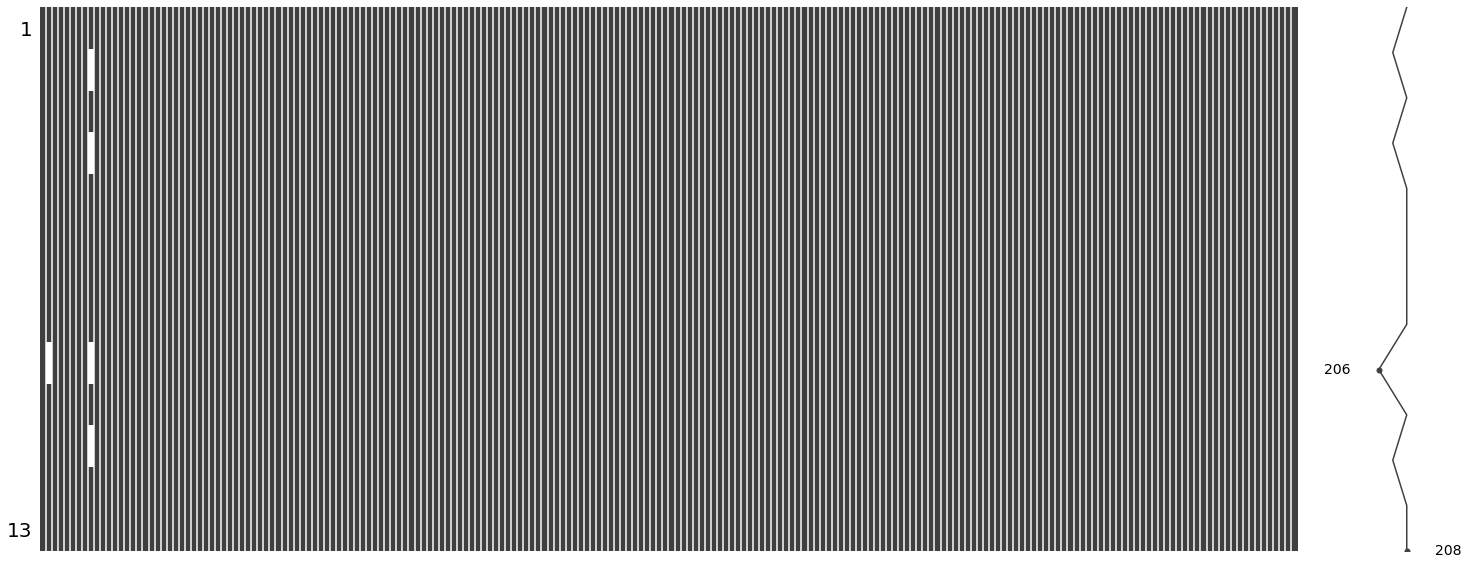

In [33]:
#Generamos la base de Registros para la totalidad de municipios, que se usará para las predicciones, no se tiene en cuenta dt_circuito y dt_distrito, que no cuentan con informción de todos los municipios
#Existen valores nulos en los delitos de 27 municipios 
nulos=pd.DataFrame(Registros_compl.isnull().sum())
nulos.columns=['conteo']
nulos.sort_values(by='conteo', ascending=False)[0:2]

#Se observa que los valores nulos se encuentran en los mismos municipios y constituyen las variables relacionadas a delitos
msno.matrix(Registros_compl)

<AxesSubplot:>

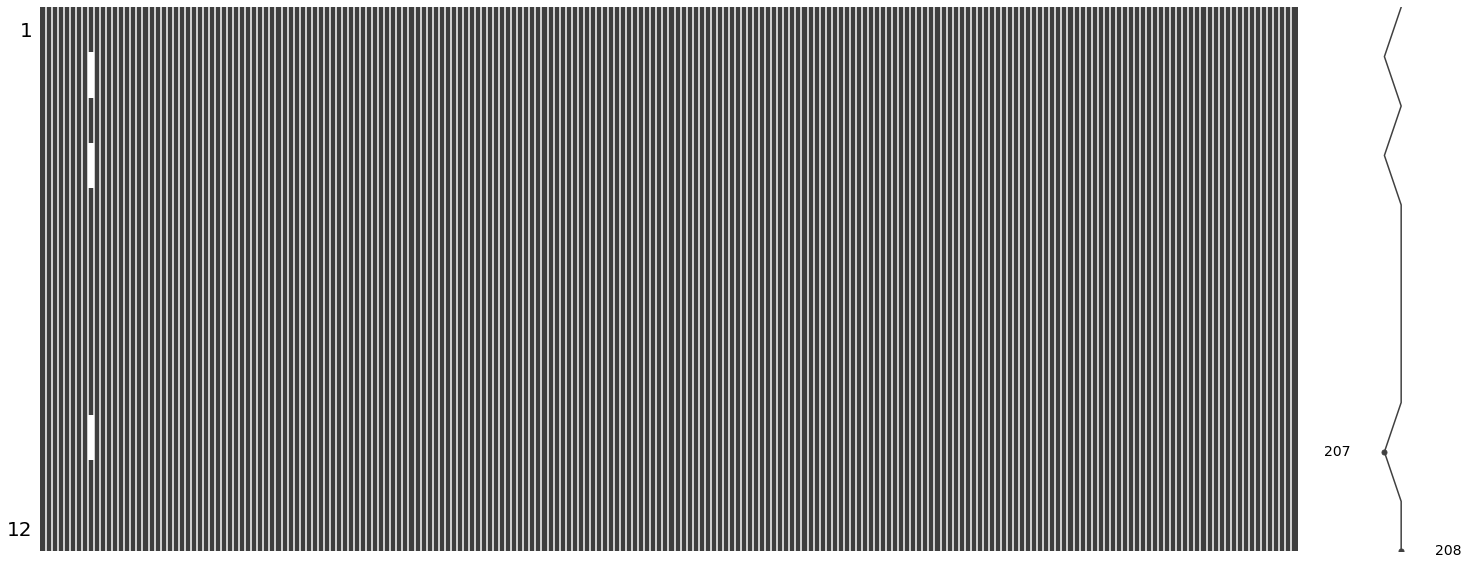

In [34]:
#Se eliminan los municipios que no cuentan con información de delitos
#Se eliminaron 27 municipios
Registros_compl_sin_na=Registros_compl[Registros_compl['Abigeato'].notna()]
#Verificamos que la base de datos ahora cuenta con datos completos
msno.matrix(Registros_compl_sin_na)

In [35]:
#Se convierten las variables numéricas
var=list(Registros_compl_sin_na.drop(columns=['mpio_cnmbr', 'dpto_cnmbr']).columns) 
Registros1=Registros_compl_sin_na[var].replace(",", ".", regex=True)
Registros1=Registros1.apply(pd.to_numeric)
Registros_compl_sin_na=pd.concat([Registros1, Registros_compl_sin_na[['mpio_cnmbr', 'dpto_cnmbr']]], axis=1)

In [36]:
Registros_compl_sin_na.head()

,mpio_ccnct,Abigeato,Amenazas,DelitosSexuales,Extorsion,Homicidios,HurtoAutomotores,HurtoComercio,HurtoFinancieras,alfabetas,...,sas_cab,sas_cprd,trinf_tot,trinf_cab,trinf_cprd,triml_tot,triml_cab,triml_cprd,mpio_cnmbr,dpto_cnmbr
0,76001,20.0,3999.0,1995.0,500.0,1114.0,2103.0,3976.0,18.0,1645436,...,17.8,16.5,0.6,0.5,0.7,75.3,75.1,80.6,CALI,VALLE DEL CAUCA
1,52001,8.0,865.0,527.0,76.0,53.0,83.0,541.0,NaN,315714,...,16.0,11.2,0.8,0.5,2.1,81.8,79.9,89.8,PASTO,NARIÑO
2,17001,6.0,152.0,405.0,43.0,55.0,7.0,437.0,1.0,362810,...,17.4,17.7,0.4,0.4,1.0,70.4,70.0,77.9,MANIZALES,CALDAS
3,66001,8.0,233.0,604.0,100.0,124.0,35.0,799.0,NaN,368145,...,18.5,17.3,0.6,0.5,1.1,75.4,74.7,79.1,PEREIRA,RISARALDA
4,5001,5.0,546.0,2460.0,630.0,581.0,953.0,5110.0,7.0,2143618,...,15.9,15.5,0.5,0.5,1.1,71.0,70.9,77.3,MEDELLÍN,ANTIOQUIA


In [37]:
#Se corre la siguiente linea para exportar la base completa de registros
carpeta_salida='datos_intermedios'
ruta_salida2 = os.path.join(carpeta_actual, carpeta_salida, '2_Base_completa_registros_ECSC2019.xlsx')
Registros_compl_sin_na.to_excel(ruta_salida2, index=False)